<a href="https://colab.research.google.com/github/seansothey/CSC685/blob/master/Project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [61]:
# Common Import
import sklearn
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
import time
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report, mean_squared_error
from math import sqrt

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# sklearn version > 0.20 is required 
sklearn.__version__
# Update sklearn -> !pip install -U scikit-learn

'0.22.2.post1'

#Data Scrubbing

##Loading Data

In this section, loading and viewing data are shown.

In [62]:
df = pd.read_csv('https://raw.githubusercontent.com/seansothey/CSC685/master/diabetic_data.csv')
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


##Exploring Data

here, the data will be investigated to see if there is missing data and also to figure out any other issue in the data.


See the data information

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
weight                      101766 non-null object
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            10176

Here is more information about data.

In [64]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


Next, check the number of object types.

In [65]:
df.dtypes.value_counts()

object    37
int64     13
dtype: int64

It is concluded that there are total 50 columns/features. The breakdown is as follows:
- 2 columns are target variable/labels ('diabetesMed and 'readmitted'), both has nominal value.
- 48 columns are features, and 35 columns has nominal value and 13 columns has numeric value.

Check if there is 'NaN' value in the data

In [66]:
df.isna().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

From the above, there is no 'NaN' value in dataframe.

From the sample data above, the missing data were marked as '?'. Let see in the dataframe and count them.

In [67]:
missing_data=df.isin(['?']).sum()
missing_data

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

Calculate the percentage of the missing for the column that has that.

In [0]:
#Custom function to calculate the precentage of an attribute
def cal_Percentage(attributeName,missing_data=missing_data,dataFrame=df):
    print('{0}: {1:.2f} % missing data'.format(attributeName,missing_data[attributeName]/len(df)*100))

In [69]:
for att in missing_data.keys():
  if missing_data[att] > 0:
    cal_Percentage(att)

race: 2.23 % missing data
weight: 96.86 % missing data
payer_code: 39.56 % missing data
medical_specialty: 49.08 % missing data
diag_1: 0.02 % missing data
diag_2: 0.35 % missing data
diag_3: 1.40 % missing data


From the above, it shows that the follwing attributes has missing data:
1.   race 2%
2.   weight 97%
3.   payer_code 40% 
4.   medical_specialty 49%
5.   diag_1 0.02%
6.   diag_2 0.35%
7.   diag_3 1.40%

##Features Engineering


Let's see the correlation of each feature using heatmap.

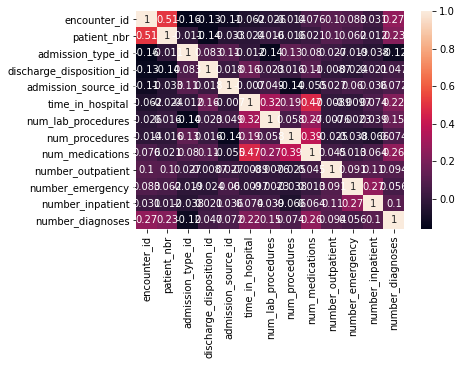

In [70]:
corr = df.corr()
sns.heatmap(corr, annot = True)

This can be seen that there aren't any high correlation (value >0.8) between each feature. However, this doesn't mean that all features are needed to be used to fit the learning model, such as patient_id, physician_id, payer_id, etc. The data value of these types are meaningless for aggregation, like mean, total, min and max, etc. Therefore, as a data scientist, this should be able to defined before conducting feature engineering

Now, let's drop some columnus that has value as id and missing value greater than 70%

In [71]:
data = df.drop(['encounter_id','patient_nbr','weight','admission_type_id','discharge_disposition_id',
                  'admission_source_id','payer_code','medical_specialty','diag_1','diag_2','diag_3'], axis=1)

data.shape

(101766, 39)

##Data Visualization

Display data in histgram charts to see how is the data distributed.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fde09f7a630>,
      dtype=object)

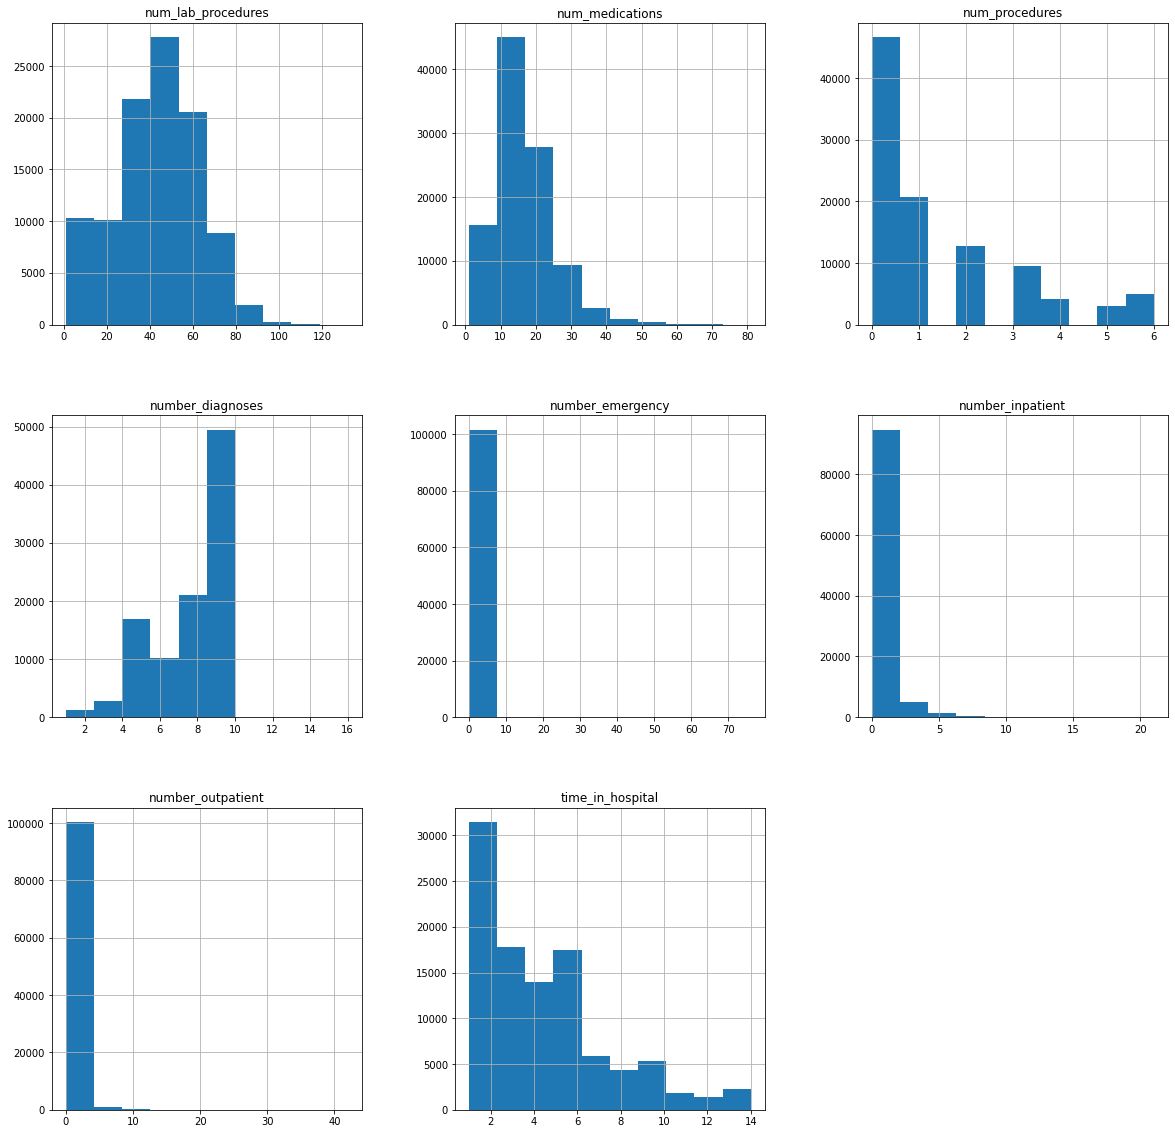

In [72]:
data.hist(figsize=(20,20))

In [0]:
def groupByChart(attr,title):

  count_y_genered=data.groupby(attr).count()
  plt.figure(figsize=(20,10))
  count = 0;

  attr=count_y_genered.keys()
  cats=count_y_genered[attr[0]].keys()
  #To assign a color for each catagory
  colors = dict()

  for cat in cats:
    random_number = random.randint(0,16777215)
    hex_number = str(hex(random_number))
    hex_number ='#'+ hex_number[2:]
    colors[cat]=hex_number
  #To assign a position for each catogory
  positions = dict()
  for key in attr:
    for cat in cats:
      positions[cat]=count_y_genered[key][cat]

  barWidth = 0.9
  for key in attr:
    for cat in cats:
      plt.bar(-0.20+count,count_y_genered[key][cat],color=colors[cat],width=barWidth)
      count +=1

  plt.legend(cats)
  plt.xticks([(barWidth+r-0.85)*len(cats) for r in range(len(attr))],attr,rotation=90)
  plt.title(title)
  plt.show()

##Group By Gender


In [74]:
data.groupby('gender').count()

,race,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
gender,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Female,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708,54708
Male,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055,47055
Unknown/Invalid,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


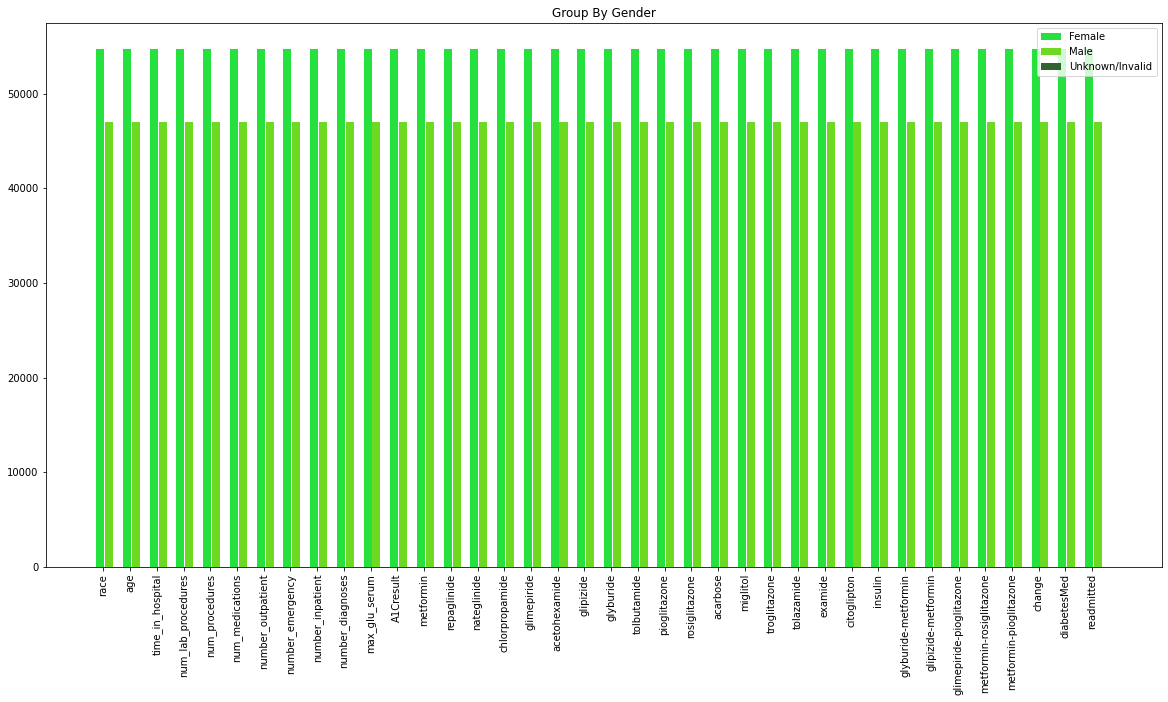

In [75]:
groupByChart('gender','Group By Gender')

##Group By Age

In [76]:
data.groupby('age').count()

,race,gender,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
age,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
[0-10),161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161,161
[10-20),691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691,691
[20-30),1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657,1657
[30-40),3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775,3775
[40-50),9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685,9685
[50-60),17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256,17256
[60-70),22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483,22483
[70-80),26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068,26068
[80-90),17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197,17197


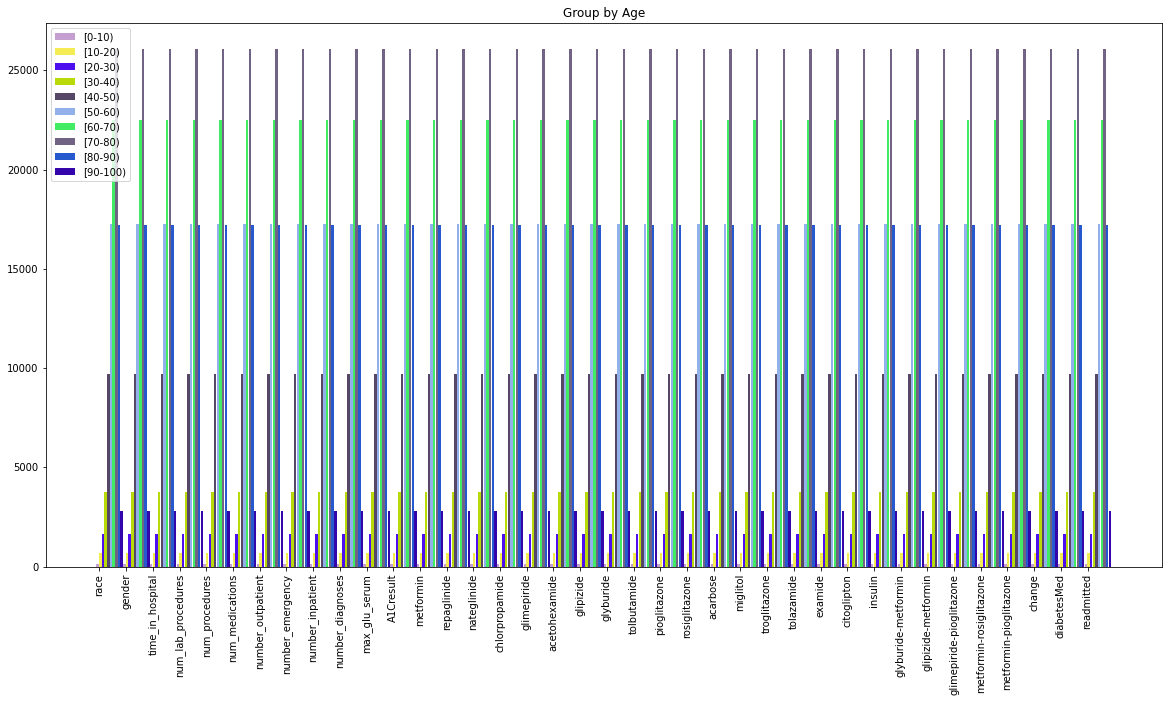

In [77]:
groupByChart('age','Group by Age')

##Group By Race


In [78]:
data.groupby('race').count()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
?,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273,2273
AfricanAmerican,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210,19210
Asian,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641,641
Caucasian,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099,76099
Hispanic,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037
Other,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506,1506


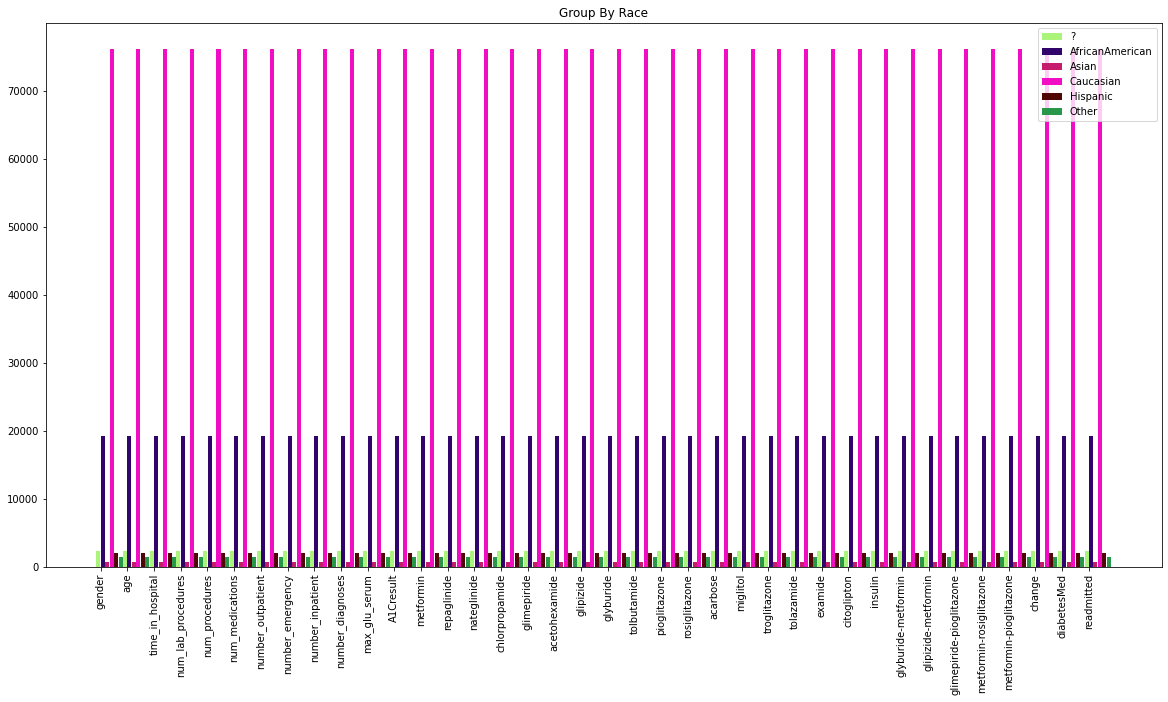

In [79]:
groupByChart('race','Group By Race')

##Group By Diabetes Medication Prescribed

In [80]:
data.groupby('diabetesMed').count()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,readmitted
diabetesMed,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
No,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403,23403
Yes,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363,78363


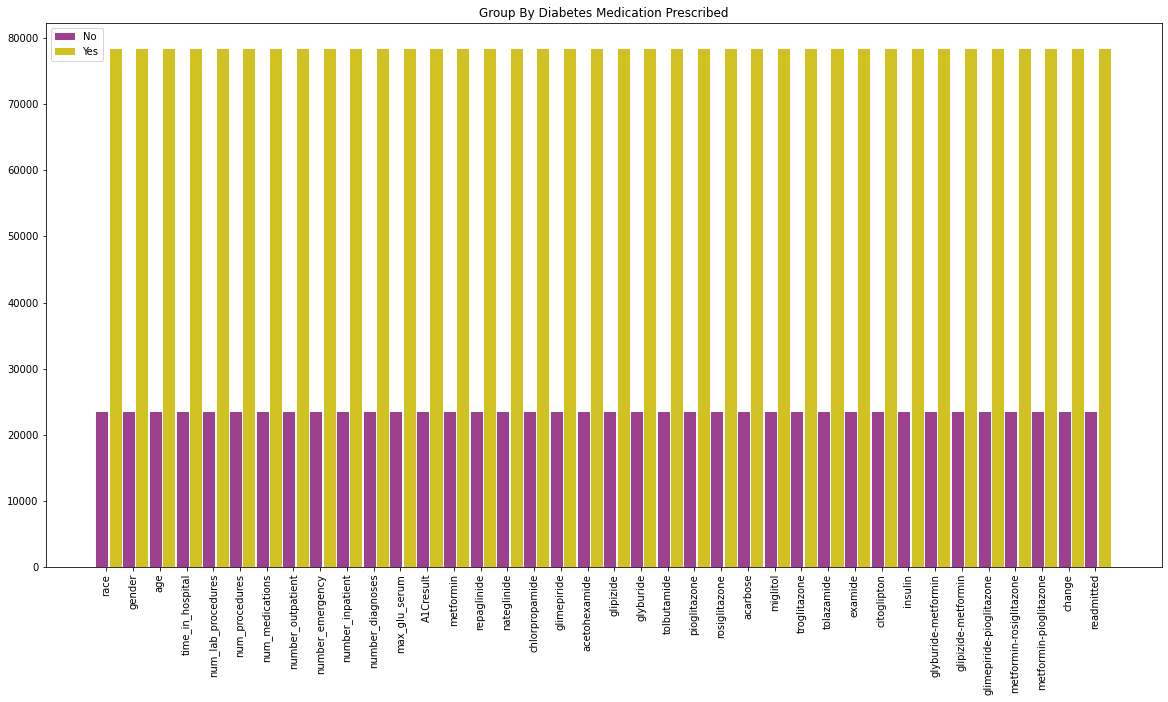

In [81]:
groupByChart('diabetesMed','Group By Diabetes Medication Prescribed')

## Group by Readmitted

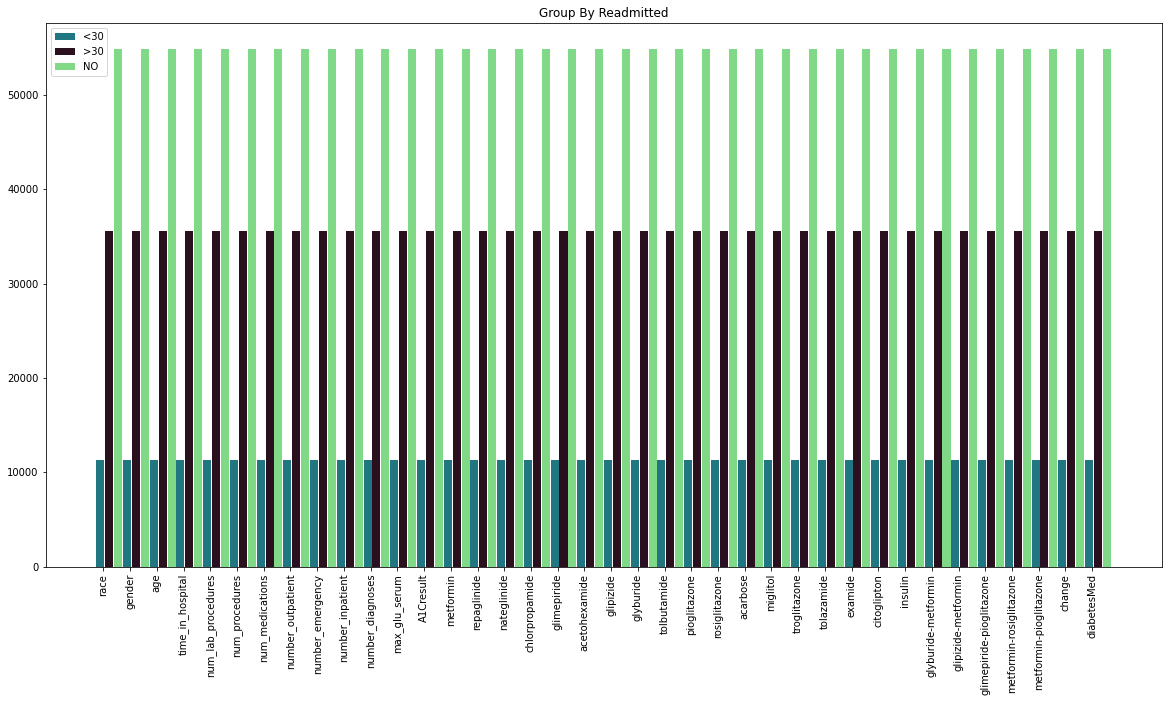

In [145]:
groupByChart('readmitted','Group By Readmitted')

#Normalization

Normlizing the features that has numerical value

In [0]:
scaler = MinMaxScaler(feature_range=[0, 3])
data.iloc[:,3:11] = scaler.fit_transform(data.iloc[:,3:11])

In [84]:
data.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),0.000000,0.916031,0.0,0.0000,0.000000,0.0,0.000000,0.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,[10-20),0.461538,1.328244,0.0,0.6375,0.000000,0.0,0.000000,1.6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,[20-30),0.230769,0.229008,2.5,0.4500,0.142857,0.0,0.142857,1.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,[30-40),0.230769,0.984733,0.5,0.5625,0.000000,0.0,0.000000,1.2,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,[40-50),0.000000,1.145038,0.0,0.2625,0.000000,0.0,0.000000,0.8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


##Choose X features y labels

In [0]:
X_diabetesMed = data.iloc[:,0:37]
X_readmitted = data.iloc[:,0:38] #Including diabetesMed as a feature
y_diabetesMed = data.iloc[:,-2] #diabetesMed target
y_readmitted = data.iloc[:,-1] #readmitted target

In [86]:
X_diabetesMed.shape, y_diabetesMed.shape, X_readmitted.shape, y_readmitted.shape

((101766, 37), (101766,), (101766, 38), (101766,))

In [87]:
X_diabetesMed.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change
0,Caucasian,Female,[0-10),0.000000,0.916031,0.0,0.0000,0.000000,0.0,0.000000,0.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),0.461538,1.328244,0.0,0.6375,0.000000,0.0,0.000000,1.6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch
2,AfricanAmerican,Female,[20-30),0.230769,0.229008,2.5,0.4500,0.142857,0.0,0.142857,1.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
3,Caucasian,Male,[30-40),0.230769,0.984733,0.5,0.5625,0.000000,0.0,0.000000,1.2,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch
4,Caucasian,Male,[40-50),0.000000,1.145038,0.0,0.2625,0.000000,0.0,0.000000,0.8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch


In [88]:
X_readmitted.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
0,Caucasian,Female,[0-10),0.000000,0.916031,0.0,0.0000,0.000000,0.0,0.000000,0.0,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No
1,Caucasian,Female,[10-20),0.461538,1.328244,0.0,0.6375,0.000000,0.0,0.000000,1.6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
2,AfricanAmerican,Female,[20-30),0.230769,0.229008,2.5,0.4500,0.142857,0.0,0.142857,1.0,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes
3,Caucasian,Male,[30-40),0.230769,0.984733,0.5,0.5625,0.000000,0.0,0.000000,1.2,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes
4,Caucasian,Male,[40-50),0.000000,1.145038,0.0,0.2625,0.000000,0.0,0.000000,0.8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes


##Convert categorical value to numerical

In [0]:
X_diabetesMed = pd.get_dummies(X_diabetesMed)
X_readmitted = pd.get_dummies(X_readmitted)

In [90]:
X_diabetesMed.shape, X_readmitted.shape

((101766, 108), (101766, 110))

convert 'diabetesMed' label to numerical

In [91]:
y_dia = y_diabetesMed.map(lambda x:int(1) if x=='Yes' else int(0))
y_dia.head()

0    0
1    1
2    1
3    1
4    1
Name: diabetesMed, dtype: int64

convert 'readmitted' label to numerical

In [92]:
y_rea = y_readmitted.map(lambda x:int(0) if x=='No' else int(1) if x=='<30' else int(2))
y_rea.head()

0    2
1    2
2    2
3    2
4    2
Name: readmitted, dtype: int64

##Select the best 50 features from both diabetes and readmitted

In [0]:
skb = SelectKBest(chi2, k=50)
X_dia = skb.fit_transform(X_diabetesMed,y_dia)
X_rea = skb.fit_transform(X_readmitted,y_rea)

In [0]:
# For vizaulizing the important features
X_dia_fit = skb.fit(X_diabetesMed, y_dia)
X_rea_fit = skb.fit(X_readmitted, y_rea)

In [96]:
X_dia.shape, X_rea.shape

((101766, 50), (101766, 50))

###Best 50 features for 'diabetesMed'

In [0]:
X_dia_scores=pd.DataFrame(X_dia_fit.scores_)
X_dia_columns = pd.DataFrame(X_diabetesMed.columns)
dia_scores = pd.concat([X_dia_columns,X_dia_scores],axis=1)
dia_scores.columns=['Features','Score']

See the 50 highest score of importance features

In [98]:
print(dia_scores.nlargest(50,'Score'))

                  Features       Score
6         number_inpatient  994.937608
0         time_in_hospital  120.382533
90            insulin_Down   92.357920
5         number_emergency   64.870867
91              insulin_No   60.224382
108                    NaN   57.655322
22             age_[50-60)   38.833315
37        metformin_Steady   38.724389
93              insulin_Up   38.245607
7         number_diagnoses   29.059329
3          num_medications   24.786171
106              change_Ch   20.833336
18             age_[10-20)   20.107193
8                   race_?   19.133618
107              change_No   17.886877
109                    NaN   17.218681
2           num_procedures   16.521367
19             age_[20-30)   15.882274
25             age_[80-90)   14.795801
17              age_[0-10)   14.034622
32            A1Cresult_>8   13.767366
28      max_glu_serum_>300   12.728291
34          A1Cresult_Norm   11.333367
4        number_outpatient   11.281901
36            metformin_N

###Best 50 features for 'readmitted'

In [0]:
X_rea_scores = pd.DataFrame(X_rea_fit.scores_)
X_rea_columns = pd.DataFrame(X_readmitted.columns)
rea_scores=pd.concat([X_rea_columns,X_rea_scores],axis=1)
rea_scores.columns = ['Features','Score']

In [100]:
print(rea_scores.nlargest(50,'Score'))

                  Features       Score
6         number_inpatient  994.937608
0         time_in_hospital  120.382533
90            insulin_Down   92.357920
5         number_emergency   64.870867
91              insulin_No   60.224382
108         diabetesMed_No   57.655322
22             age_[50-60)   38.833315
37        metformin_Steady   38.724389
93              insulin_Up   38.245607
7         number_diagnoses   29.059329
3          num_medications   24.786171
106              change_Ch   20.833336
18             age_[10-20)   20.107193
8                   race_?   19.133618
107              change_No   17.886877
109        diabetesMed_Yes   17.218681
2           num_procedures   16.521367
19             age_[20-30)   15.882274
25             age_[80-90)   14.795801
17              age_[0-10)   14.034622
32            A1Cresult_>8   13.767366
28      max_glu_serum_>300   12.728291
34          A1Cresult_Norm   11.333367
4        number_outpatient   11.281901
36            metformin_N

#Splitting The Data

Here, Split the data for training and testing set in ration 70%-30%

In [0]:
#For diabetesMed
X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X_dia,y_dia, test_size=0.3, shuffle = True, random_state=42)

In [0]:
#For readmitted
X_train_rea, X_test_rea, y_train_rea, y_test_rea = train_test_split(X_rea,y_rea, test_size=0.3, shuffle = True, random_state=42)

#Building The Models

##RandomForest Model

In [0]:
rnd_clf = RandomForestClassifier(n_estimators=10)

###for 'diabetMed'

Perform Cross Validation


In [104]:
cross_val_score(rnd_clf, X_train_dia, y_train_dia, cv=3, scoring='accuracy').mean()

0.9992981090774866

Fit the model with training set

In [0]:
t0 = time.time()
rnd_clf.fit(X_train_dia, y_train_dia)
t1 = time.time()

In [106]:
print("Training took {:.2f}s".format(t1-t0))

Training took 0.38s


Test the model with testing set

In [107]:
rnd_clf.score(X_test_dia, y_test_dia)

0.9994431706518179

###for 'readmitted'

Perform Cross Validation

In [108]:
cross_val_score(rnd_clf, X_train_rea, y_train_rea, cv=3, scoring='accuracy').mean()

0.8773794209630594

Fit the model with training set

In [0]:
t0 = time.time()
rnd_clf.fit(X_train_rea, y_train_rea)
t1 = time.time()

In [110]:
print("Training took {:.2f}s".format(t1-t0))

Training took 0.96s


Test the model with testing set

In [111]:
rnd_clf.score(X_test_rea, y_test_rea)

0.8754667540124468

Predict y 'readmitted'

In [0]:
y_pred_rnd_rea = rnd_clf.predict(X_test_rea)

See Precision, Recall and F1 report

In [113]:
print(classification_report(y_test_rea, y_pred_rnd_rea))

              precision    recall  f1-score   support

           1       0.22      0.04      0.07      3425
           2       0.89      0.98      0.93     27105

    accuracy                           0.88     30530
   macro avg       0.56      0.51      0.50     30530
weighted avg       0.82      0.88      0.84     30530



##SVM (nom-linear kernel) Model

In [0]:
svm_clf = svm_clf = SVC(gamma='auto', degree=2, kernel='poly') #Non-linear degree=2

###for 'diabetMed'

Perform Cross Validation

In [115]:
cross_val_score(svm_clf, X_train_dia, y_train_dia, cv=3, scoring='accuracy').mean()

0.9948200407235673

Fit the model with training set

In [0]:
t0 = time.time()
svm_clf.fit(X_train_dia, y_train_dia)
t1 = time.time()

In [117]:
print("Training took {:.2f}s".format(t1-t0))

Training took 180.99s


Test the model with testing set

In [118]:
svm_clf.score(X_test_dia, y_test_dia)

0.9972813625941697

###for 'readmitted'

Perform Cross Validation

In [119]:
cross_val_score(svm_clf, X_train_rea, y_train_rea, cv=3, scoring='accuracy').mean()

0.8886518052231157

Fit the model with training set

In [0]:
t0 = time.time()
svm_clf.fit(X_train_rea, y_train_rea)
t1 = time.time()

In [121]:
print("Training took {:.2f}s".format(t1-t0))

Training took 165.09s


Test the model with testing set

In [122]:
svm_clf.score(X_test_rea, y_test_rea)

0.8878152636750737

Predict y 'readmitted'

In [0]:
y_pred_svm_rea = svm_clf.predict(X_test_rea)

See Precision, Recall and F1 report

In [124]:
print(classification_report(y_test_rea, y_pred_svm_rea))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      3425
           2       0.89      1.00      0.94     27105

    accuracy                           0.89     30530
   macro avg       0.44      0.50      0.47     30530
weighted avg       0.79      0.89      0.84     30530



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Plot the learning curve for 'readmitted'

In [0]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  if axes is None:
        _, axes = plt.subplots(2, 1, figsize=(20, 5))

  axes.set_title(title)
  if ylim is not None:
        axes.set_ylim(*ylim)
  axes.set_xlabel("Training examples")
  axes.set_ylabel("Score")

  train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  # Plot learning curve
  axes.grid()
  axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
  axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
  axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
  axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
  axes.legend(loc="best")
  return plt

Plot the learning curve for both RandomForest and SVC. For SVC, displaying the curve takes long time so a subset of size 10,000 of the data will be used to fast generate the chart.

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


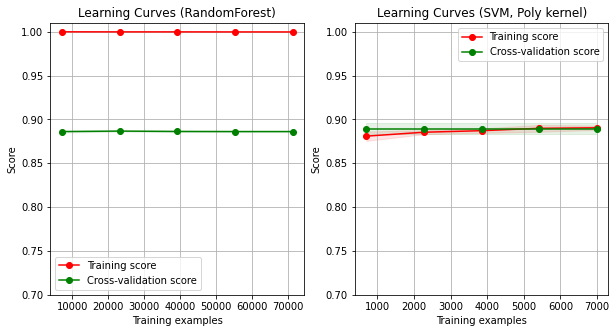

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

X, y = X_rea, y_rea

title = "Learning Curves (RandomForest)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)

estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, axes=axes[0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = "Learning Curves (SVM, Poly kernel)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
estimator = SVC(gamma='auto')
plot_learning_curve(estimator, title, X[:10000], y[:10000], axes=axes[1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

#Use GridSearchCV to find the best model (Hyperparameter Tuning) 

Using subset size 10000 to avoid time consuming

RandomForest Model

In [0]:
rnd_pipe = make_pipeline(RandomForestClassifier())
# Create dictionary with candidate learning algorithms and their hyperparameters
rnd_param = [
                {"randomforestclassifier": [RandomForestClassifier()],
                 "randomforestclassifier__n_estimators": [10,50,100],
                 "randomforestclassifier__max_depth":[10,30,50,None],
                 "randomforestclassifier__min_samples_leaf":[5,10,20,50],
                 "randomforestclassifier__max_leaf_nodes": [5,10,20,50]}
              ]

create a gridsearch of the pipeline, then fit the dataset to find best model

In [0]:
rnd_gs = GridSearchCV(rnd_pipe, rnd_param, verbose=0,n_jobs=-1)

Fit the model with training set

In [0]:
rnd_best_model = rnd_gs.fit(X_train_rea[:10000], y_train_rea[:10000])

See the best learning model parameters

In [130]:
print(rnd_best_model.best_estimator_)

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=30, max_features='auto',
                                        max_leaf_nodes=50, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)


Test the model with testing set

In [131]:
print(("The accuracy is:"), rnd_best_model.score(X_test_rea[:10000], y_test_rea[:10000]))

The accuracy is: 0.8886


SVM Model

In [0]:
# Create dictionary with candidate learning algorithms and their hyperparameters
svm_param = [
             {'kernel': ['rbf'], 'gamma': [0.1,0.2],'C': [1,10]},
             {'kernel': ['linear'], 'gamma': [0.1,0.2],'C': [1,10]},
             {'kernel': ['poly'], 'gamma': [0.1,0.2],'C': [1,10]}
            ]

create a gridsearch of the pipeline, then fit the dataset to find best model

In [0]:
svm_gs = GridSearchCV(SVC(), svm_param)

Fit the model with training set

In [0]:
svm_best_model = svm_gs.fit(X_train_rea[:10000], y_train_rea[:10000])

See the best learning model parameters

In [135]:
print(svm_best_model.best_estimator_)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


Test the model with testing set

In [136]:
print(("The accuracy is:"), svm_best_model.score(X_test_rea[:10000], y_test_rea[:10000]))

The accuracy is: 0.8886


Let's generate additional features from existing features, hopefully it will give a better accuracy.  
Let's use the top highest important features.

In [0]:
X_readmitted['in-out-patient'] = X_readmitted['number_inpatient'] * X_readmitted['number_outpatient']
X_readmitted['num-diag-medi'] = X_readmitted['number_diagnoses'] * X_readmitted['num_medications']

In [138]:
X_readmitted.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Female,gender_Male,gender_Unknown/Invalid,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),age_[60-70),age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm,metformin_Down,metformin_No,metformin_Steady,metformin_Up,repaglinide_Down,...,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_Down,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_Down,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_No,troglitazone_Steady,tolazamide_No,tolazamide_Steady,tolazamide_Up,examide_No,citoglipton_No,insulin_Down,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_Down,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_No,glipizide-metformin_Steady,glimepiride-pioglitazone_No,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_No,metformin-rosiglitazone_Steady,metformin-pioglitazone_No,metformin-pioglitazone_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes,in-out-patient,num-diag-medi
0,0.000000,0.916031,0.0,0.0000,0.000000,0.0,0.000000,0.0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,1,0,0.000000,0.000
1,0.461538,1.328244,0.0,0.6375,0.000000,0.0,0.000000,1.6,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0.000000,1.020
2,0.230769,0.229008,2.5,0.4500,0.142857,0.0,0.142857,1.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0.020408,0.450
3,0.230769,0.984733,0.5,0.5625,0.000000,0.0,0.000000,1.2,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0.000000,0.675
4,0.000000,1.145038,0.0,0.2625,0.000000,0.0,0.000000,0.8,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,1,0.000000,0.210


Select Features

In [0]:
skb = SelectKBest(chi2, k=100)
X_new = skb.fit_transform(X_readmitted,y_rea)

In [140]:
X_new.shape

(101766, 100)

Split the training and testing set

In [0]:
#For readmitted
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new,y_rea, test_size=0.3, shuffle = True, random_state=42)

Using RandomForest with the best model parameters we found above

In [0]:
rnd_clf_new = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=50, max_features='auto',
                                        max_leaf_nodes=50, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=5, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False)

Fit the model with training set

In [143]:
rnd_clf_new.fit(X_train_new, y_train_new)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=50, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Test the model with testing set

In [144]:
rnd_clf_new.score(X_test_new, y_test_new)

0.8878152636750737

It is clearly proved that, adding extra features from existing features also will not improve the learning performace.

#Summary and Conclusion


In this diabete patients dataset, many methods were used at the data cleansing section, especially at the feature engineering phase.

For 'diabetesMed' classification, accuracy produced by both models is same 99%, but SVM model learning time took very much longer than RandomForest. 

For 'readmitted' classification, accuracy produced by both models is also same 88%, and once again SVM computation time is much longer. Let's assume time is not matter, which classifier predict better if both produced same accuracies? By looking at the average F1 score, RandomForest F1=0.5 > SVM F1=0.47, this mean RandomForest model predict better in term of precision and recall.  
See the barcharts below for the experiment summary base on features selection. This two barcharts indicated that increasing number of features did not effect to the model performance at all.

![alt text](https://github.com/seansothey/CSC685/blob/master/diabetesMed-report-project5.PNG?raw=true)

![alt text](https://github.com/seansothey/CSC685/blob/master/readmitted-report-project5.PNG?raw=true)

Now, how can we improve the performance for 'readmitted' patients classification? According to the Learning curve behaviour, getting more sample set size will not improve the accuracy.

GridSearchCV was used to tune up both classifiers for readmitted patient. By looking at GridSearchCV learning model with many different parameters setup, the performance was still not improved. 

Overall, RandomForest is considered for best learning model for this dataset. And trying to get some new information (features) from patients may improve the classification of 'readmitted' patients.  


*Note: An important lesson learned from this data set was when applying PCA and scaling the data was not helpful and even made the model performance worse. This is because most of the data value are categorical (0,1,2 after convertion), therefore, the classifiers would learn better with this descrete value.*

#Refrences



*   https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

*   https://sju.instructure.com/courses/20477/files/2050722?module_item_id=691863

*   https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html



